# Bagian B
---
**Implementasi Mini-batch Gradient Descent**

Anggota : 
- Jovan Karuna Cahyadi (13518024)
- Ricky Fernando (13518062)
- Stefanus Stanley Yoga Setiawan (13518122)
- William (13518138)

# External Library & Notebook Sanity Check
---
Berikut library eksternal yang kami gunakan :
- numpy
- pandas



In [ ]:
import pandas as pd
import math
import numpy as np
import json
import matplotlib.pyplot as plt

from copy import deepcopy
from json import JSONEncoder
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# Utility Function

---
Terdapat beberapa fungsi _utility_ yang kami buat untuk mempermudah tahapan pembangunan Neural Network, sebagai berikut:

Sementara itu, fungsi - fungsi _activation_ yang telah dibuat pada bagian A sebelumnya diubah agar dapat menghitung nilai derivasi fungsi, yaitu:




In [ ]:
###################
# Model Selection #
###################
def one_hot_encoder(y):
  b = np.zeros((y.size, y.max()+1))
  b[np.arange(y.size),y] = 1
  return b
  
#################
# Loss Function #
#################

def mse(y_pred, y, derivative=False):
  if derivative:
    return -1*(y-y_pred)
  return 0.5*(y-y_pred)**2

def cross_entropy(y_pred, y):
  n_data = len(y[0])
  res = []
  for i in range(n_data):
    target = y[:, i]
    target_index = np.where(target==1)[0][0]
    err = -np.log(y_pred[:, i][target_index])
    res.append(err)
  return np.array(res)

#######################
# Activation Function #
#######################

def relu(x, derivative=False):
  if derivative:
    return 1
  return np.maximum(0, x)

def linear(x, derivative=False):
  if derivative:
    return 1
  return x

def sigmoid(x, derivative=False):
  if derivative:
    return x*(1-x)
  return 1/(1+np.exp(-x))

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(res, y):
  lists=[]
  n_data = len(y[0])
  res_copy = deepcopy(res)
  y_copy = deepcopy(y)
  y_transpose = y_copy.T
  res_transpose = res_copy.T
  for i in range(n_data):
    target = list(y_transpose[i])
    target_index = target.index(1)
    res_transpose[i][target_index] = -(1-res_transpose[i][target_index])
  return res_transpose.T 

####################
# Scoring Function #
####################

def accuracy_score(y_pred, y_test):
  isOneHot = len(y_pred[0]) == 1
  if not isOneHot:
    t_y_pred = np.zeros_like(deepcopy(y_pred))
    t_y_pred[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    count = 0
    total = len(t_y_pred)
    for i in range(total):
      if(not np.array_equal(t_y_pred[i], y_test[i])):
        count += 1
    return 1 - count/total
  else:
    count = 0
    total = y_pred.shape[0]
    for a, b in zip(y_pred, y_test):
      if np.round(a) == np.round(b):
        count += 1
    return count/total

from keras import backend as K
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#######################
# External File Utils #
#######################
def export_to_json(data, filename):
  
  class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

  with open(filename, "w") as json_file:  
    json.dump(data, json_file, cls=NumpyArrayEncoder) 
  

def import_from_json(filename):
  with open(filename, 'r') as json_file: 
    data = json.load(json_file)
  if data is not None : 
    return data
  else :
    print("No data found!")

def activation_func_identifier(func_name):
  return {
    "sigmoid" : sigmoid,
    "softmax" : softmax,
    "linear" : linear,
    "relu" : relu
  }.get(func_name)

def activation_func_dump(func):
  return {
    sigmoid : "sigmoid",
    softmax : "softmax",
    linear : "linear",
    relu : "relu"
  }.get(func)

def create_history(ann):
  for i, hist in enumerate(ann.history):
    if i == 0:
      print('Input Layer')
    else:
      print(f'Layer {i}')
    for j, value in enumerate(hist):
      if i == 0:
        print(f'    Features {j} = {value}')
      else:
        print(f'    σ(Out Nodes {j}) = {value}')

# Artificial Neural Network Representation

In [ ]:
class HiddenLayer():
  """
  Attributes:
    weights (np.array) -> with shape (n_nodes, n_features)
      weights[nodes][features]
    prev_res (np.array) -> with shape (n_features, n_data)
      prev_res[features][n]
    out (np.array) -> with shape (n_nodes, n_data)
    bias (np.array) -> with shape (n_nodes)
    activation_function (function) -> activation function for this layer
  
  Method:
    calculate_out -> dot product between input and nodes weight
  """
  def __init__(self, nodes, activation_function, prev_res=None):
    """
    Parameters:
      nodes (tuple(int, int)) -> Create matrix weights
      activation_function (function) -> activation function for this layer
      prev_res (np.array) -> with shape (n_nodes_before, n_data), first layer
      shape is (n_features, n_data), next layer will be initialize with None
      because no output yet from nodes before
    """
    self.weights = np.random.uniform(0, 1, nodes)
    self.out = None
    self.prev_res = prev_res
    self.bias = np.random.uniform(0, 1, (1, self.weights.shape[0]))
    self.activation_function = activation_function

  def calculate_out(self, prev_res):
    """
    Calculate dot product between weights and inputs
    Formula:
      activation(Weights . value_before + bias)

    Parameters:
      prev_res (np.array) -> Input given to layer
    """
    self.prev_res = prev_res
    mult = self.weights @ self.prev_res
    for i in range(self.weights.shape[0]):
      mult[i] += self.bias[0][i]
    self.out = self.activation_function(mult)

  def __str__(self):
    return f'{self.weights}'

In [ ]:
class BuildError(Exception):
  """
  Exception when build ANN
  """
  def __init__(self, message):
    super().__init__(message)

In [ ]:
class ANNClassifier():
  """
  Attributes:
    x (np.array) -> with shape (n_features, n_data)
    y (np.array) -> with shape (n_data, n_class or 1)
    learning_rate (float) -> learning_rate for training
    metrics (function) -> metrics for evaluation
    verbose (int) -> output message training every epoch
    layers (list(HiddenLayer)) -> last layer is output layer
    loss_hist (list(float)) -> loss history 
    score_hist (list(float)) -> score history
    history (list(float)) -> input from every layer
    
  Method:
    __feed_forward -> feed forward in ANN
    __back_propagation -> back propagation in ANN
    __create_batch -> create mini batch data
    add -> insert layer to ANN
    compile -> compile model
    train -> train model
    predict -> predict data
    save -> saving model
    load -> loading model
    plot_loss -> plotting loss in train
    plot_score -> plotting score in train
  """
  def __init__(self, verbose=1):
    self.verbose = verbose
    self.layers = []
    self.score_hist = []
    self.history = []
    self.loss_hist = []

  def __feed_forward(self, batch):
    """
    Feed Forward method used in ANN which calculate input and produce output
    using dot product in every layer

    Parameters:
      batch (np.array) -> Used data

    Formula:
      res[0] = input
      res[1] = activation(Weights[0] . res[0] + bias[0])
      res[2] = activation(Weights[1] . res[1] + bias[1])
      .
      ..
      ...
      res[n] = activation(Weights[n-1] . res[n-1] + bias[n-1])
      output = activation(Weights[n] . res[n] + bias[n])
    """
    self.layers[0].prev_res = batch[0]
    prev_res = self.layers[0].prev_res
    for layer in self.layers:
      layer.calculate_out(prev_res)
      prev_res = layer.out
  
  def __back_propagation(self, batch):
    """
    Backpropagation method
    Step:
      1. Calculate dE/dOut (error'(output layer))
      2. Calculate dOut/dNet (activation'(output layer))
      3. Calculate dNet/dW (input layer)
      4. Calculate multiplication from dEdOut and dOutdNet
      5. Calculate mult by multiply dEdOut with dOutdNet. If not last layer,
         need to times mult before with dOutdNet and dot product it with
         transpose previous layer weights
      6. Find step using dot product between mult and transpose dNetdW (nabla)
      7. Updating weight
      8. Repeat until all weights updated
    """
    prev_layer = deepcopy(self.layers[-1])

    if (activation_func_dump(self.layers[-1].activation_function) == "softmax"):
      dEdNet = softmax_derivative(self.layers[-1].out, batch[1].T)
      mult = dEdNet
    else:
      dEdOut = self.loss(self.layers[-1].out, batch[1].T, derivative=True)
      dOutdNet = self.layers[-1].activation_function(
          self.layers[-1].out, derivative=True)
      mult = dEdOut * dOutdNet

    dNetdW = self.layers[-1].prev_res
    nabla = mult @ dNetdW.T
    self.layers[-1].weights -= self.learning_rate * nabla

    # bias
    x = np.matrix([[1] * self.layers[-1].bias.shape[0]] * self.layers[-1].prev_res.shape[1])
    nabla_bias = mult @ x
    self.layers[-1].bias -= self.learning_rate * nabla_bias.T
    
    for layer in np.flip(self.layers)[1:]:
      dOutdNet = layer.activation_function(layer.out, derivative=True)
      mult = prev_layer.weights.T @ mult * dOutdNet
      dNetdW = layer.prev_res
      nabla = mult @ dNetdW.T
      prev_layer = deepcopy(layer)
      layer.weights -= self.learning_rate * nabla

      # Update bias
      x = np.matrix([[1] * layer.bias.shape[0]] * layer.prev_res.shape[1])
      nabla_bias = mult @ x
      layer.bias -= self.learning_rate * nabla_bias.T
    
  def __create_batch(self):
    """
    Create mini batch data as many as batch size

    Return:
      batches -> mini batch after splitting
    """
    batches = []
    data = self.x.T
    n_data = data.shape[0]
    n_batch = n_data // self.batch_size
    total = 0

    for i in range(self.batch_size):
      start = self.batch_size * i
      if i == self.batch_size - 1:
        mini_batch = (data[start:].T, self.y[start:])
      else:
        end = start + n_batch
        mini_batch = (data[start:end].T, self.y[start:end])
        total += end-start
      batches.append(mini_batch)
    
    return batches

  def compile(self, 
              x, 
              y, 
              learning_rate=0.1, 
              metrics=accuracy_score, 
              loss=mse,
              batch_size=16):
    """
    Compiling model before training

    Parameters:
      x (np.array) -> input data with shape (n_features, n_data)
      y (np.array) -> target input with shape (n_data, n_class or 1)
      learning_rate (int) -> learning rate used for training
      metrics (function) -> metrics used to evaluate model performance
      loss (function) -> error function for training and evaluate model 
                         performance
      batch_size (int) -> batch used every training
    
    Throws:
      BuildError -> batch size > data size
    """
    if batch_size > x.shape[0]:
      raise BuildError("Input Batch Size should be < data size")
    if (activation_func_dump(self.layers[-1].activation_function) == 'softmax')\
     and (loss != cross_entropy):
      raise BuildError("Softmax output layer must use cross entropy loss function")

    self.x = x.T
    self.y = y
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.loss = loss
    self.batch_size = batch_size

  def train(self, epochs=5, error_threshold = 0.0001):
    """
    Training model
    Step:
      1. Splitting batch
      2. Feed Forward
      3. Back Propagation (Including updating weight)
    """
    self.epochs = epochs
    batches = self.__create_batch()

    for _ in range(epochs):
      for batch in batches:
        self.__feed_forward(batch)
        self.__back_propagation(batch)

      out = self.predict(self.x, trained=True)
      error = np.sum(self.loss(out.T, self.y.T))
      score = self.metrics(out, self.y)

      if self.verbose == 1:
        print('Epochs {0}, loss = {1:.8f}, score = {2:.8f}'
              .format(_+1, error, score))
      
      self.loss_hist.append(error)
      self.score_hist.append(score)
      if (error < error_threshold) :
        self.epochs = _+1
        print(f'Train Terminated because loss < loss_threshold ({error} < {error_threshold})')
        break

  def add(self, nodes, input_dim=None, activation_function=sigmoid):
    """
    Add another Hidden Layer into ANNClassifier
    
    Parameters:
      nodes (int) -> how many nodes in the layer
      input_dim (int) -> dimension of input data (Used only for the first layer)
      activation_function (function) -> what activation function used in the 
      layer
    """
    if len(self.layers) == 0:
      if (input_dim is None):
        raise BuildError("This is input layer, please provide input_dim in parameter")
      weights_shape = (nodes, input_dim)
      layer = HiddenLayer(weights_shape, activation_function)
    else:
      weights_shape = (nodes, self.layers[-1].weights.shape[0])
      layer = HiddenLayer(weights_shape, 
                          activation_function)
    self.layers.append(layer)

  def predict(self, in_val, trained=False):
    """
    Predict given data

    Parameters:
      in_val (np.array) -> with shape (n_data, n_features)
    
    Return:
      prev_res -> predicted value
    """
    self.history = []
    if not trained:
      prev_res = np.array(in_val).T
    else:
      prev_res = np.array(in_val)
    for layer in self.layers:
      self.history.append(prev_res)
      layer.calculate_out(prev_res)
      prev_res = layer.out
    self.history.append(prev_res)
    return prev_res.T
  
  def save(self, filename):
    """
    Save layers, layers weights and activation_function
    """
    layers = list(map(
      lambda layer : {
        "nodes" : layer.weights.shape[0],
        "weights" : layer.weights,
        "bias" : layer.bias,
        "activation" : activation_func_dump(layer.activation_function)
      }, 
      self.layers
    ))

    if (self.verbose > 1):
      print("Export:")
      pprint(layers)

    export_to_json(layers, filename)


  def load(self, filename):
    """
    Load layers, layers weights and activation function
    """
    layers = import_from_json(filename)

    if (self.verbose > 1):
      print("Import : ")
      pprint(layers)

    for count, layer in enumerate(layers) : 
      if count == 0:
        self.add(layer['nodes'], input_dim=len(layer['weights'][0]),
                 activation_function=
                 activation_func_identifier(layer['activation']))
      else:
        self.add(layer['nodes'], activation_function = 
                 activation_func_identifier(layer['activation']))
      self.layers[-1].weights = np.array(layer['weights'])
      self.layers[-1].bias = layer['bias']
  
  def summary(self):
    """
    Summary of the model (layers, shape, params, and weight)
    """
    if len(self.layers) == 0:
      raise BuildError('You need to build the model first')
    summary = []
    dim = self.layers[0].weights.shape[1]
    for count, layer in enumerate(self.layers) :
      param = (dim + 1) * layer.weights.shape[0] 
      dim = layer.weights.shape[0]
      summary.append({
          'layer': f'dense_{count} (Dense)',
          'output': layer.weights.shape[0],
          'activation': layer.activation_function.__name__,
          'param': param,
          'weight': layer.weights,
          'bias' : layer.bias
      })

    print("SUMMARY")
    print("====================================")
    print(f'Layer (Type)\t: Input Layer')
    print(f'Activation\t: None')
    print(f'Output Shape\t: {self.layers[0].weights.shape[1]}')
    print(f'Param\t\t: -')

    total_param = 0
    for layer in summary:
      total_param += layer['param']
      print("====================================")
      print(f'Layer (Type)\t: {layer["layer"]}')
      print(f'Activation\t: {layer["activation"]}')
      print(f'Output Shape\t: {layer["output"]}')
      print(f'Param\t\t: {layer["param"]}')
      print("Weight\t\t:")
      for count, weight in enumerate(layer["weight"]):
        print(f'\tnode_{count} {weight}')
      print(f'\tbias {layer["bias"][0]}')
    
    print("====================================")
    print(f"Total params : {total_param}")

  def plot_loss(self):
    plt.plot(range(self.epochs), self.loss_hist, color = 'r')
    plt.ylabel('error')
    plt.xlabel('epochs')
    plt.title('Error')
    plt.show()

  def plot_score(self):
    plt.plot(range(self.epochs), self.score_hist, color = 'r')
    plt.ylabel('scores')
    plt.xlabel('epochs')
    plt.title('Score')
    plt.show()

  def get_init_weights(self):
    if len(self.layers) == 0:
      raise BuildError('You need to build the model first')
    
    init_weights= []
    for layer_number in range (len(model.layers)):
      weights = []
      for idx, weights_in_node in enumerate(self.layers[layer_number].weights):
        count=0
        while (count < len(weights_in_node)):
          if (idx == 0):
            weights.append([weights_in_node[count]])
          else:
            weights[count].append(weights_in_node[count])
          count = count+1
      bias = self.layers[layer_number].bias[0].copy() 
      init_weights.append([np.array(weights), bias])
      
    return init_weights

# Hasil Hipotesis (ANN) vs PPT
---
Berikut kami sertakan contoh pembelajaran dan hasil dari ANN yang kami buat dengan contoh data masukan pada PPT kuliah

In [ ]:
x = np.array([[0.05, 0.1]])
y = np.array([[0.01, 0.99]])

In [ ]:
model = ANNClassifier()
model.add(2, input_dim=x.shape[1], activation_function=sigmoid)
model.add(2, activation_function=sigmoid)

In [ ]:
model.layers[0].weights = np.array([[0.15, 0.2],
                                    [0.25, 0.3]])
model.layers[0].bias = np.array([[0.35, 0.35]])
model.layers[1].weights = np.array([[0.4, 0.45],
                                    [0.5, 0.55]])
model.layers[1].bias = np.array([[0.6, 0.6]])

In [ ]:
model.compile(x, y, learning_rate=0.5, batch_size=1, loss=mse)

In [ ]:
model.train(epochs=1)

Epochs 1, loss = 0.28047145, score = 0.00000000


In [ ]:
model.summary()

SUMMARY
Layer (Type)	: Input Layer
Activation	: None
Output Shape	: 2
Param		: -
Layer (Type)	: dense_0 (Dense)
Activation	: sigmoid
Output Shape	: 2
Param		: 6
Weight		:
	node_0 [0.14978072 0.19956143]
	node_1 [0.24975114 0.29950229]
	bias [0.34561432 0.34502287]
Layer (Type)	: dense_1 (Dense)
Activation	: sigmoid
Output Shape	: 2
Param		: 6
Weight		:
	node_0 [0.35891648 0.40866619]
	node_1 [0.51130127 0.56137012]
	bias [0.53075072 0.61904912]
Total params : 12


# Testing
---
Pada tahap ini, kami melakukan pengujian ANN yang berhasil kami susun dengan 2 data uji, yaitu : 
* Breast Cancer Data (untuk pengujian _binary classification_)
* Iris Data (untuk pengujian _multiclass classification_)

## Sigmoid for binary classification

In [ ]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
x = breast_cancer['data']
y = breast_cancer['target']
y = y.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = scale.fit_transform(x)

In [ ]:
model = ANNClassifier()
model.add(2, input_dim=x.shape[1], activation_function=sigmoid)
model.add(1, activation_function=sigmoid)

In [ ]:
model.compile(x, y, learning_rate=0.5, batch_size=5, metrics=accuracy_score)
model.train(epochs=10, error_threshold=2)

Epochs 1, loss = 104.37626306, score = 0.62741652
Epochs 2, loss = 5.48259242, score = 0.97188049
Epochs 3, loss = 5.89603837, score = 0.97539543
Epochs 4, loss = 3.49347026, score = 0.98594025
Epochs 5, loss = 4.98715964, score = 0.97891037
Epochs 6, loss = 6.21850029, score = 0.97012302
Epochs 7, loss = 3.42362272, score = 0.98594025
Epochs 8, loss = 3.14192023, score = 0.98769772
Epochs 9, loss = 3.01704188, score = 0.98945518
Epochs 10, loss = 2.91646823, score = 0.98945518


In [ ]:
y_pred = np.round(model.predict(x))
accuracy_score(y_pred, y)

0.9894551845342706

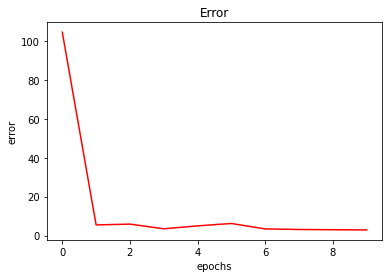

In [ ]:
model.plot_loss()

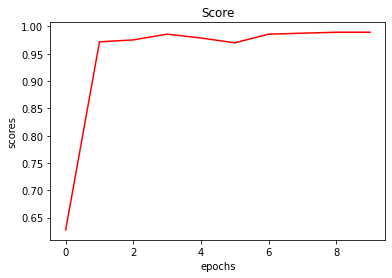

In [ ]:
model.plot_score()

## Softmax for multiclass classification

In [ ]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
x = iris_dataset['data']
y = iris_dataset['target']
b = one_hot_encoder(y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = scale.fit_transform(x)

In [ ]:
model = ANNClassifier()
model.add(4, input_dim=x.shape[1], activation_function=sigmoid)
model.add(3, activation_function=softmax)

In [ ]:
model.summary()

SUMMARY
Layer (Type)	: Input Layer
Activation	: None
Output Shape	: 4
Param		: -
Layer (Type)	: dense_0 (Dense)
Activation	: sigmoid
Output Shape	: 4
Param		: 20
Weight		:
	node_0 [0.9528225  0.34410054 0.15633799 0.1180927 ]
	node_1 [0.91196374 0.36245569 0.35573044 0.11640537]
	node_2 [0.12287745 0.28548617 0.62902441 0.39981368]
	node_3 [0.3083528  0.59451145 0.46102819 0.48106642]
	bias [0.14755317 0.10038262 0.10820599 0.97794824]
Layer (Type)	: dense_1 (Dense)
Activation	: softmax
Output Shape	: 3
Param		: 15
Weight		:
	node_0 [0.28059706 0.28660845 0.10874756 0.82724209]
	node_1 [0.67520696 0.78536967 0.33662002 0.82395034]
	node_2 [0.97873227 0.66301027 0.20706783 0.93128402]
	bias [0.64864507 0.28723782 0.15471414]
Total params : 35


In [ ]:
model.compile(x, b, learning_rate=0.1, loss=cross_entropy, batch_size=5)
model.train(epochs=50)

Epochs 1, loss = 1616.24092588, score = 0.33333333
Epochs 2, loss = 88.64288702, score = 0.62000000
Epochs 3, loss = 128.33002578, score = 0.62666667
Epochs 4, loss = 649.76467504, score = 0.66666667
Epochs 5, loss = 525.52371404, score = 0.33333333
Epochs 6, loss = 857.35076326, score = 0.66666667
Epochs 7, loss = 92.72811540, score = 0.59333333
Epochs 8, loss = 271.21223318, score = 0.53333333
Epochs 9, loss = 91.17399866, score = 0.61333333
Epochs 10, loss = 161.41467173, score = 0.50666667
Epochs 11, loss = 70.33312281, score = 0.88000000
Epochs 12, loss = 89.96715317, score = 0.86000000
Epochs 13, loss = 86.52846079, score = 0.90000000
Epochs 14, loss = 100.33316933, score = 0.84666667
Epochs 15, loss = 86.60517013, score = 0.92000000
Epochs 16, loss = 49.71116347, score = 0.91333333
Epochs 17, loss = 36.76672760, score = 0.94000000
Epochs 18, loss = 16.95338724, score = 0.96666667
Epochs 19, loss = 16.25909514, score = 0.97333333
Epochs 20, loss = 10.63856294, score = 0.96000000


In [ ]:
y_pred = model.predict(x)
accuracy_score(y_pred, b)

0.9866666666666667

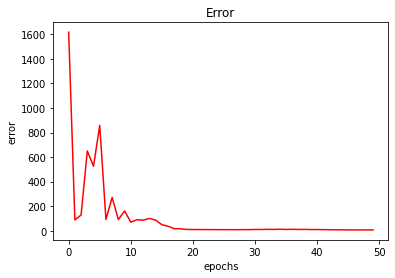

In [ ]:
model.plot_loss()

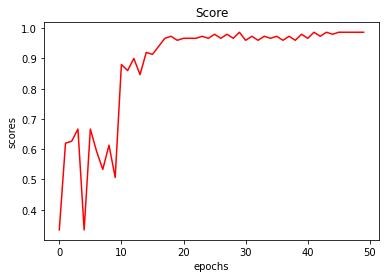

In [ ]:
model.plot_score()

# Comparison (vs MLP Sklearn)
---
Sebagai pembanding dan referensi hasil dari pengujian ANN yang kami lakukan, berikut kami sertakan pengujian dengan menggunakan _MLPClassifier_ dari sklearn dengan data yang serupa dengan pengujian sebelumnya


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

mlp_clf = MLPClassifier(random_state=42, hidden_layer_sizes=(4,), solver='sgd', activation='logistic',
                      alpha=0, batch_size=5, learning_rate_init=0.5, power_t=0, 
                      max_iter=50, shuffle=False, verbose=True, momentum=0,
                      beta_1=0, beta_2=0, n_iter_no_change=50)

In [ ]:
mlp_clf.fit(x, b)

Iteration 1, loss = 1.39859113
Iteration 2, loss = 1.18834130
Iteration 3, loss = 0.96562343
Iteration 4, loss = 0.87619095
Iteration 5, loss = 0.80741905
Iteration 6, loss = 0.73831561
Iteration 7, loss = 0.66999424
Iteration 8, loss = 0.60326280
Iteration 9, loss = 0.53826584
Iteration 10, loss = 0.47654172
Iteration 11, loss = 0.42024099
Iteration 12, loss = 0.37090558
Iteration 13, loss = 0.32901527
Iteration 14, loss = 0.29419604
Iteration 15, loss = 0.26560392
Iteration 16, loss = 0.24224095
Iteration 17, loss = 0.22314777
Iteration 18, loss = 0.20749002
Iteration 19, loss = 0.19457893
Iteration 20, loss = 0.18386086
Iteration 21, loss = 0.17489644
Iteration 22, loss = 0.16733879
Iteration 23, loss = 0.16091442
Iteration 24, loss = 0.15540766
Iteration 25, loss = 0.15064814
Iteration 26, loss = 0.14650099
Iteration 27, loss = 0.14285911
Iteration 28, loss = 0.13963716
Iteration 29, loss = 0.13676683
Iteration 30, loss = 0.13419321
Iteration 31, loss = 0.13187189
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0, batch_size=5, beta_1=0, beta_2=0,
              early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(4,),
              learning_rate='constant', learning_rate_init=0.5, max_fun=15000,
              max_iter=50, momentum=0, n_iter_no_change=50,
              nesterovs_momentum=True, power_t=0, random_state=42,
              shuffle=False, solver='sgd', tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [ ]:
test_pred = mlp_clf.predict(x)
print(accuracy_score(test_pred, b))

0.9666666666666667


# Laporan

--- 

## A. Implementasi Mini-batch Gradient Descent
Implementasi dilakukan dengan cara menambah atribut batch_size pada class ANN. Atribut ini akan digunakan nantinya pada saat training yaitu dengan membuat batch-batch sesuai dengan *batch_size* yang telah ditentukan. Untuk setiap batchnya maka akan dilakukan __Forward Propagation__ dan __Backward Propagation__. Foward Propagation akan melakukan perhitungan untuk setiap input sampai output. Backward Propagation digunakan untuk menghitung error dan sekaligus mengupdate weight yang ada pada layer tersebut untuk setiap node (termasuk bias).

Implementasi backpropagation yang dilakukan adalah dengan mengimplementasi metode ____back_propagation__. metode ini melakukan aturan rantai untuk menghitung error dari layer output ke layer input.

Untuk fungsi aktivasinya sendiri, kami telah mengimplementasikan 4 jenis fungsi aktivasi beserta derivasinya untuk _loss_ function (sigmoid, linear, relu, dan softmax)

Dalam implementasi ANN dengan _Mini-batch Gradient Descent_ kami sendiri, terdapat beberapa parameter yang dapat ditangani, sebagai berikut : 
- __jumlah layer__ : layer dapat ditambah dengan memanfaatkan method _add_ pada ANN.
- __jumlah neuron setiap layer__ : jumlah neuron tiap layer dapat diubah / dimodifikasi saat instansiasi layer, dengan memberikan argumen sesuai dengan jumlah neuron yang diinginkan saat pembuatan layer ANN.
- __activation function__ : fungsi aktivasi tiap layernya diatur pada tahap pembuatan layer, dengan parameter *activation_function*. Sebagai catatan, untuk 1 layer yang sama seluruh node akan menggunakan fungsi aktivasi yang serupa.
- __learning-rate__ : learning rate dari ANN dapat diatur saat melakukan **compile** terhadap model melalui parameter *learning_rate*.
- __error threshold__: untuk mengubah / modifikasi terkait *error threshold* saat pembelajaran model dilakukan dengan menambahkan parameter *error_threshold* saat akan melakukan train.
- **batch_size** : besar batch saat training dapat diatur saat melakukan **compile** terhadap model ANN, melalui parameter *batch_size* 

## B. Hasil Eksekusi
Percobaan yang dilakukan adalah dengan melakukan testing terhadap model sigmoid dan softmax. Model sigmoid digunakan untuk klasifikasi kelas biner sedangkan pada model softmax digunakan untuk klasifikasi multiclass.

Model Sigmoid yang dibangun memiliki 2 layer dengan 2 node untuk hidden layer dan 1 node untuk output layer. Kedua fungsi aktivasi menggunakan sigmoid. Model ini dilakukan sebanyak 10 epoch dengan *learning rate* 0.5 dan *batch_size* 5. Model dilakukan training untuk dataset *breast cancer* dan menunjukkan akurasi prediksi dari model adalah 98,95%.

Model Softmax yang dibangun memiliki 2 layer dengan 4 node untuk hidden layer dan 3 node untuk output layer. Hidden node menggunakan fungsi aktivasi sigmoid dan output layer menggunakan fungsi softmax. PercoaaModel ini dilakukan sebanyak 50 epoch dengan *learning rate* 0.1 dan *batch_size* 5. Model dilakukan training untuk dataset *iris* dan menunjukkan akurasi prediksi dari model adalah 98,67%.

## C. Hasil perbandingan

Sebagai bahan pembanding, kami melakukan perbandingan hasil model ANN yang telah kami bangun dengan model MLP dari sklearn. 
Konfigurasi yang kami terapkan pada MLPClassifier sebagai berikut : 
- **solver** : sgd
- **activation** : logistic
- **batch_size** : 5
- **max_iter** : 50
- **learning_rate** (init) : 0.5

Dari konfigurasi tersebut, diperoleh model MLPClassifier dengan tingkat akurasi prediksi sebesar **96,67%**. 


## D. Pembagian Kerja

| NIM      | Anggota                        | Pembagian Tugas           |
|----------|--------------------------------|---------------------------|
| 13518024 | Jovan Karuna Cahyadi           | - Melakukan analisis perbandingan model dengan library MLPClassifier <br> - Laporan|
| 13518062 | Ricky Fernando                 | - Updating bias <br>- Laporan |
| 13518122 | Stefanus Stanley Yoga Setiawan | - Membuat algoritma backpropagation <br> - Membuat mini batch gradient descent <br> - Merubah struktur kelas ANNClassifier |
| 13518138 | William                        |  - Membuat algoritma backpropagation bagian softmax <br> - Melakukan analisis pengujian perbandingan model untuk penggunaan backpropagation output layer softmax <br> - Menyusun laporan |
